In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns; sns.set() # for plot styling
import numpy as np
import tarfile
from io import BytesIO
from zipfile import ZipFile
from time import time
import sklearn
from skimage import io
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib.image import imread
import glob
import warnings
warnings.filterwarnings('ignore')
from PIL import Image

import cv2

## Load full data set

In [2]:
directory = "/Users/lamnguyen/Desktop/Capstone/food_app/food-101"
image_list = []
# Get a list of all subdirectories in the given directory
subdirectories = [f.path for f in os.scandir(directory+ "/images") if f.is_dir()]

# Loop through each subdirectory
for subdirectory in subdirectories:
    # Get the folder name
    folder_name = os.path.basename(subdirectory)

    # Get a list of all image files within the subdirectory
    image_files = [f.path for f in os.scandir(subdirectory) if f.is_file() and f.name.endswith(".jpg")]

    # Loop through each image file
    for image_file in image_files:
        # Append the image file to the image_list
        image_list.append(image_file)

In [210]:
len(image_list)

101000

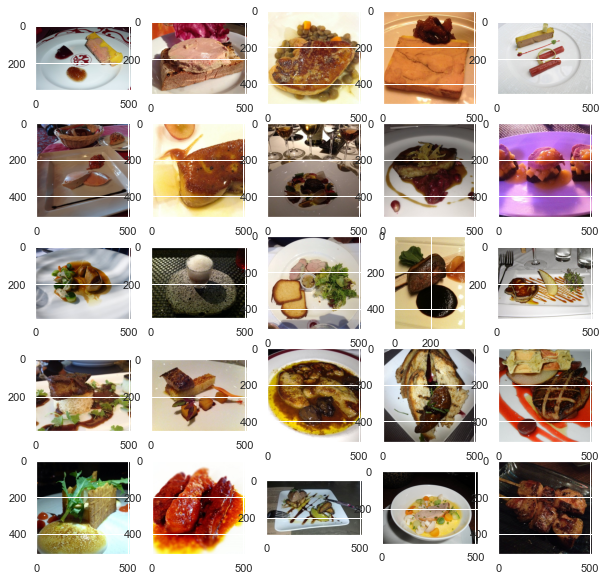

In [214]:
#plot the images
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = ax.flatten()
for i in range(25):
    path=image_list[i]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img, cmap=None)

## Load the training files

In [3]:
# Load the category labels
labels_file = directory+'/labels.txt'
with open(labels_file, 'r') as f:
    labels = [label.strip().lower().replace(' ', '_') for label in f.readlines()]

# Load the training dataset
train_file = directory+'/train.txt'
train_data = pd.read_csv(train_file, header=None, names=['category_filename'], dtype=str)
train_data['category'] = train_data['category_filename'].apply(lambda x: x.split('/')[0])
train_data['filename'] = train_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
train_data['filename'] = train_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
train_data['image_path'] = train_data.apply(lambda row: os.path.join(directory, 'images', row['category'], row['filename']), axis=1)

print (train_data.shape)
train_data.head()

(75750, 4)


,category_filename,category,filename,image_path
0,apple_pie/1005649,apple_pie,1005649.jpg,/Users/lamnguyen/Desktop/Capstone/food_app/foo...
1,apple_pie/1014775,apple_pie,1014775.jpg,/Users/lamnguyen/Desktop/Capstone/food_app/foo...
2,apple_pie/1026328,apple_pie,1026328.jpg,/Users/lamnguyen/Desktop/Capstone/food_app/foo...
3,apple_pie/1028787,apple_pie,1028787.jpg,/Users/lamnguyen/Desktop/Capstone/food_app/foo...
4,apple_pie/1043283,apple_pie,1043283.jpg,/Users/lamnguyen/Desktop/Capstone/food_app/foo...


### Observe random images from different categories

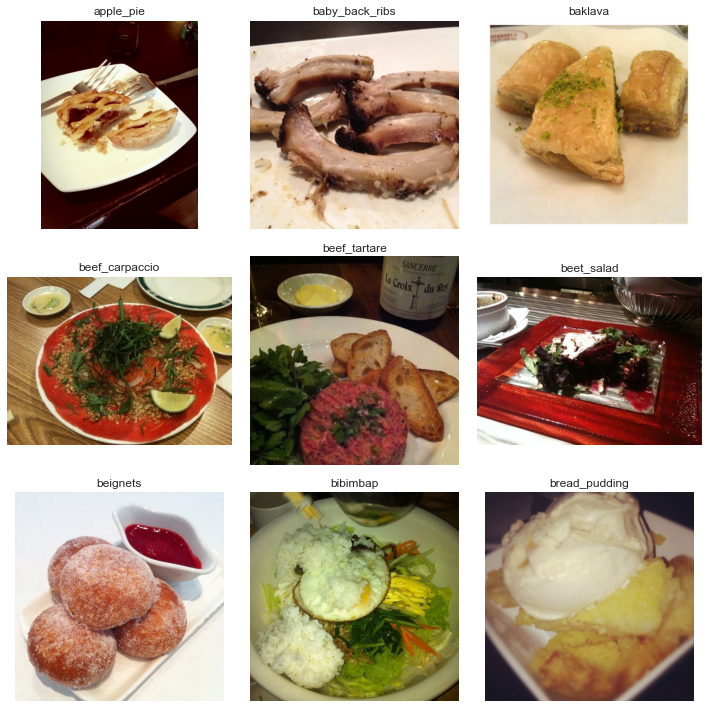

In [105]:
# Load a random sample of images from different categories
sample_images = train_data.groupby('category').apply(lambda x: x.sample(1))
sample_images_paths = []
for _, row in sample_images.iterrows():
    category = row['category']
    filename = row['filename']
    image_path = f'{directory}/images/{category}/{filename}'
    sample_images_paths.append(image_path)

plt.figure(figsize=(10, 10))
num_images = min(len(sample_images_paths), 9)
num_rows = num_cols = int(num_images ** 0.5)
for i, image_path in enumerate(sample_images_paths[:num_images]):
    plt.subplot(num_rows, num_cols, i+1)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image)  # Display the image
    plt.title(sample_images.iloc[i]['category'])
    plt.axis('off')
plt.tight_layout()
plt.show()

### Observe images from apple pie category

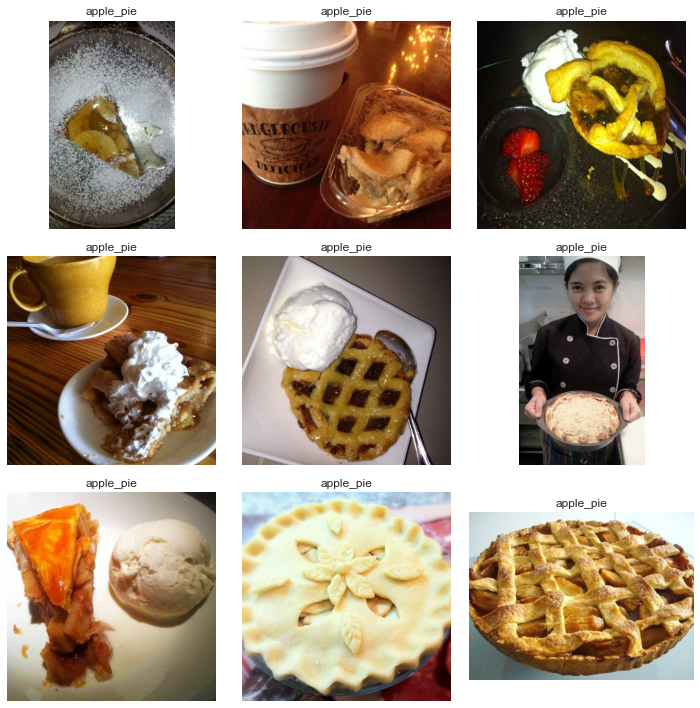

In [205]:
# Specify the category you want to plot
category_to_plot = "apple_pie"

# Filter the train_data based on the specified category
category_data = train_data[train_data['category'] == category_to_plot]

plt.figure(figsize=(10, 10))
num_images = min(len(category_data), 9)
num_rows = num_cols = int(num_images ** 0.5)
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    image_path = category_data.iloc[i]['image_path']
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image)  # Display the image
    plt.title(category_to_plot)
    plt.axis('off')
plt.tight_layout()
plt.show()

## EDA

### Explore the distribution of image size

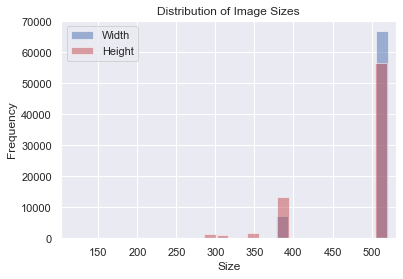

In [109]:
# Distribution of image sizes
image_sizes = []
for image_path in train_data['image_path']:
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    image_sizes.append((width, height))
    
#plot the distribution
widths, heights = zip(*image_sizes)
plt.hist(widths, bins=50, alpha=0.5, color='b', label='Width', width=15)
plt.hist(heights, bins=50, alpha=0.5, color='r', label='Height', width=15)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Image Sizes')
plt.show()

 --> Most images have high values of height and width around 525 pixels, another size shows the next high frequency is around 375 pixels.

### Explore the distribution of mean intesity and contrast of the categories

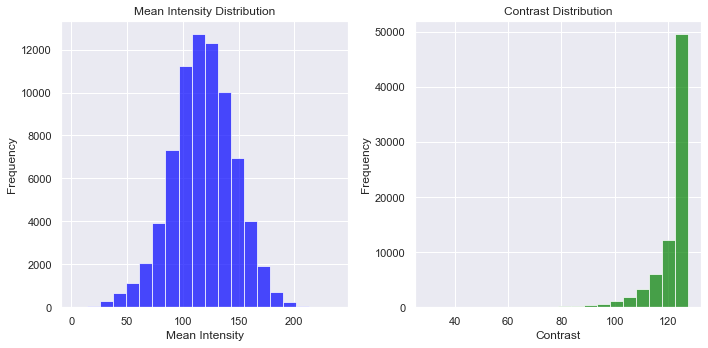

In [96]:
# Compute the mean intensity and contrast of images in the train_data dataset
mean_intensities = []
contrasts = []

for _, row in train_data.iterrows():
    image_path = row['image_path']
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the mean intensity
    mean_intensity = np.mean(gray)
    mean_intensities.append(mean_intensity)
    
    # Compute the contrast
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contrast = np.std(thresholded)
    contrasts.append(contrast)

# Plot the mean intensity and contrast
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(mean_intensities, bins=20, color='blue', alpha=0.7)
plt.title('Mean Intensity Distribution')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(contrasts, bins=20, color='green', alpha=0.7)
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

-->The mean intesity shows normal distribution of all images while contrast shows left skew distribution

### Explore the distribution of mean intesity and contrast values  for random 5 categories

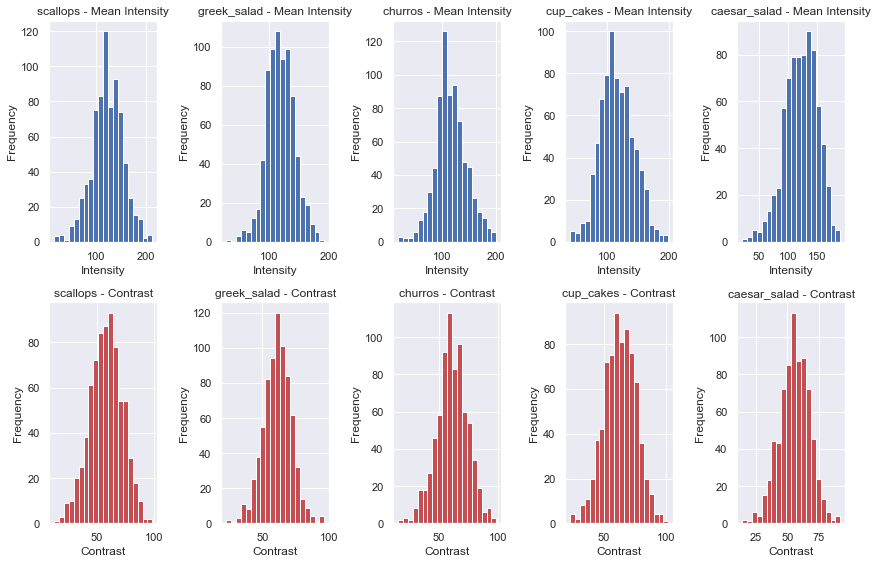

In [216]:
# Randomly select a subset of categories
num_categories = 5  
selected_categories = random.sample(labels, num_categories)

# Calculate and plot intensity and contrast for each category
plt.figure(figsize=(12, 8))
for i, category in enumerate(selected_categories):
    category_data = train_data[train_data['category'] == category]
    image_paths = category_data['image_path'].tolist()
    
    mean_intensities = []
    contrasts = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        intensity = np.mean(gray) 
        contrast = np.std(gray) 
        mean_intensities.append(intensity)
        contrasts.append(contrast)
        
    plt.subplot(2, num_categories, i + 1)
    plt.hist(mean_intensities, bins=20, color='b')
    plt.title(f'{category} - Mean Intensity')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    plt.subplot(2, num_categories, num_categories + i + 1)
    plt.hist(contrasts, bins=20, color='r')
    plt.title(f'{category} - Contrast')
    plt.xlabel('Contrast')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

 --> The distribution of mean intensity and contrast in each category selected randomly show normal or close to normal ditribution. 

### Explore the texture of the images from each category

In [6]:
import mahotas.features.texture as texture
        
# Function to compute Haralick texture features for an image
def compute_haralick_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = texture.haralick(gray)
    features = haralick.mean(axis=0)
    return features

# Analyze texture features for each category
texture_features = []
for category in labels:
    category_data = train_data[train_data['category'] == category]
    image_paths = category_data['image_path'].tolist()
    
    for image_path in image_paths:
        image = cv2.imread(image_path)
        features = compute_haralick_features(image)
        texture_features.append(features)

In [8]:
texture_features[:5]

[array([ 1.69368890e-04,  2.35126041e+02,  9.55430612e-01,  2.63858443e+03,
         1.48670150e-01,  2.30281389e+02,  1.03192117e+04,  8.60485258e+00,
         1.31815011e+01,  1.85243512e-04,  4.82814764e+00, -2.68672490e-01,
         9.90989172e-01]),
 array([ 6.21159523e-04,  7.67959920e+01,  9.91254731e-01,  4.39167211e+03,
         2.97950680e-01,  2.01225501e+02,  1.74898925e+04,  8.70189810e+00,
         1.21456420e+01,  4.30584146e-04,  3.76163023e+00, -4.26281177e-01,
         9.99230038e-01]),
 array([ 1.03368135e-03,  1.74490774e+02,  9.82195498e-01,  4.89967939e+03,
         2.80801068e-01,  1.41522470e+02,  1.94242268e+04,  8.12471086e+00,
         1.18821466e+01,  3.34641063e-04,  4.19782014e+00, -3.36994113e-01,
         9.95723300e-01]),
 array([ 4.63737281e-04,  1.11728601e+02,  9.86019772e-01,  3.99587426e+03,
         2.65652144e-01,  1.82351141e+02,  1.58717685e+04,  8.59459730e+00,
         1.22633984e+01,  3.79448082e-04,  3.95243552e+00, -3.87108175e-01,
       

In [9]:
# Create a dataframe with texture features and labels
df_texture = pd.DataFrame(texture_features, columns=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 
                                                     'Feature 5', 'Feature 6', 'Feature 7', 'Feature 8', 
                                                     'Feature 9', 'Feature 10', 'Feature 11', 'Feature 12', 
                                                     'Feature 13'])  # Replace with actual feature names
df_texture['Category'] = train_data['category']

# Compute the average texture feature values for each category
df_mean = df_texture.groupby('Category').mean()


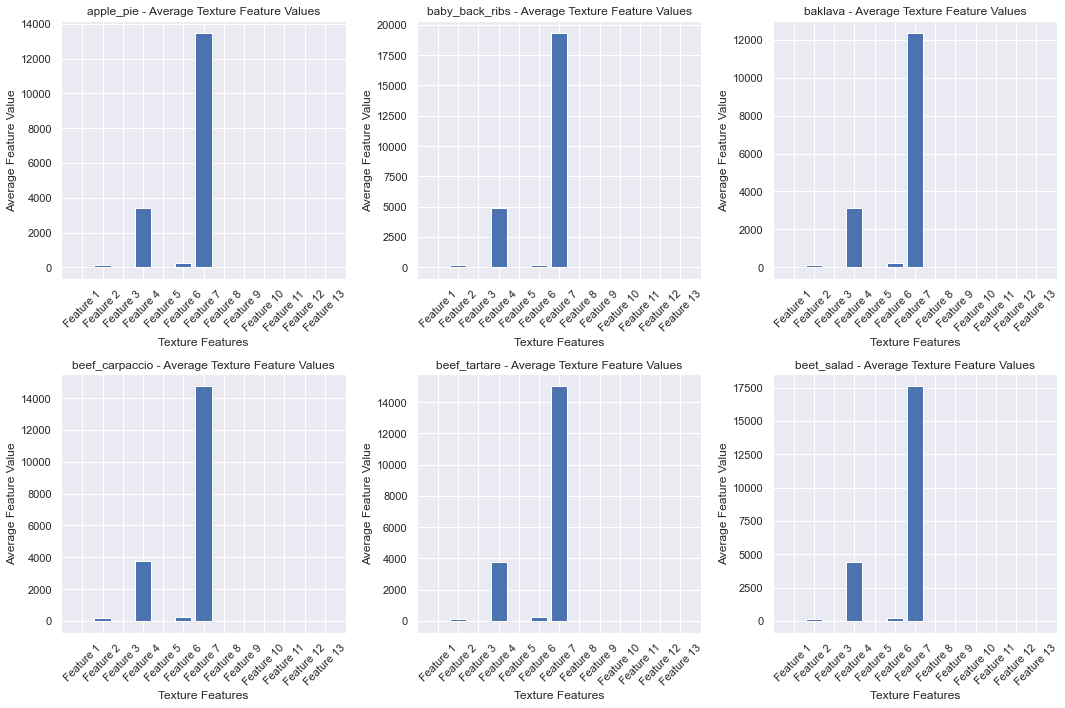

In [10]:
# Observe texture feature distibution for some categories 
num_categories_to_plot = 6 

plt.figure(figsize=(15, 10))

for i, category in enumerate(df_mean.index[:num_categories_to_plot]):
    plt.subplot(2, 3, i+1)
    plt.bar(df_mean.columns, df_mean.loc[category])
    plt.title(f'{category} - Average Texture Feature Values')
    plt.xlabel('Texture Features')
    plt.ylabel('Average Feature Value')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


Prominent features in the plot are:

Haralick Texture Feature 4: Sum of Squares Variance - It captures the variance of pixel intensities in the image.
Haralick Texture Feature 7: Sum Variance - It captures the variance of the sum values of local image regions.

--> The first 6 categories plots indicate distinct patterns and textures in the image and highlight contrast and variations in intensity or brightness

### Load test data

In [11]:
# Load the test dataset
test_file = directory+'/test.txt'
test_data = pd.read_csv(test_file, header=None, names=['category_filename'], dtype=str)
test_data['category'] = test_data['category_filename'].apply(lambda x: x.split('/')[0])
test_data['filename'] = test_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
test_data['filename'] = test_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
test_data['image_path'] = test_data.apply(lambda row: os.path.join(directory, 'images', row['category'], row['filename']), axis=1)

print (test_data.shape)
test_data.head()

(25250, 4)


,category_filename,category,filename,image_path
0,apple_pie/1011328,apple_pie,1011328.jpg,/Users/lamnguyen/Desktop/Capstone/food_app/foo...
1,apple_pie/101251,apple_pie,101251.jpg,/Users/lamnguyen/Desktop/Capstone/food_app/foo...
2,apple_pie/1034399,apple_pie,1034399.jpg,/Users/lamnguyen/Desktop/Capstone/food_app/foo...
3,apple_pie/103801,apple_pie,103801.jpg,/Users/lamnguyen/Desktop/Capstone/food_app/foo...
4,apple_pie/1038694,apple_pie,1038694.jpg,/Users/lamnguyen/Desktop/Capstone/food_app/foo...


## Modeling

### MobileNet

In [12]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder


2023-07-21 01:55:35.058506: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Create a label encoder to convert class names to numerical labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# Parameters for model training
input_shape = (224, 224, 3)
batch_size = 32
epochs = 20  

# Data augmentation for training data
train_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data generator for validation and test data (no augmentation)
test_gen = ImageDataGenerator(rescale=1.0/255.0)

#process the data
train_generator = train_gen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='category',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=labels
)

test_generator = test_gen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',
    y_col='category',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    classes=labels
)

Found 75750 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.


In [14]:
# Load MobileNet model without top layers and freeze the pre-trained layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)  # Add another  dense layers for deeper learning
predictions = Dense(len(labels), activation='softmax')(x)

mobile_net = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate for fine-tuning
mobile_net.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model 
mobile_net.fit(train_generator,
          epochs=epochs,
          steps_per_epoch=train_generator.n // batch_size)

Epoch 1/20
2367/2367 [==============================] - 1987s 838ms/step - loss: 2.6122 - accuracy: 0.3612
Epoch 2/20
2367/2367 [==============================] - 1925s 813ms/step - loss: 2.1273 - accuracy: 0.4643
Epoch 3/20
2367/2367 [==============================] - 1906s 805ms/step - loss: 2.0048 - accuracy: 0.4911
Epoch 4/20
2367/2367 [==============================] - 1881s 794ms/step - loss: 1.9323 - accuracy: 0.5062
Epoch 5/20
2367/2367 [==============================] - 1847s 780ms/step - loss: 1.8714 - accuracy: 0.5230
Epoch 6/20
2367/2367 [==============================] - 1800s 760ms/step - loss: 1.8289 - accuracy: 0.5324
Epoch 7/20
2367/2367 [==============================] - 1820s 769ms/step - loss: 1.7970 - accuracy: 0.5358
Epoch 8/20
2367/2367 [==============================] - 1799s 760ms/step - loss: 1.7724 - accuracy: 0.5438
Epoch 9/20
2367/2367 [==============================] - 1786s 754ms/step - loss: 1.7457 - accuracy: 0.5500
Epoch 10/20
2367/2367 [==============

In [15]:
# Save the model
mobile_net.save('mobile_net2')

INFO:tensorflow:Assets written to: mobile_net2/assets


INFO:tensorflow:Assets written to: mobile_net2/assets


In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = mobile_net.evaluate(test_generator, steps=test_generator.n // batch_size)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

789/789 [==============================] - 554s 701ms/step - loss: 1.6210 - accuracy: 0.5999
Test accuracy: 59.99%


### Result visualization

In [17]:
# Save the trained model weights
mobile_net.save_weights('mobilenet2_weights.h5')
# Load the pre-trained weights
mobile_net.load_weights('mobilenet2_weights.h5')

790/790 [==============================] - 572s 724ms/step


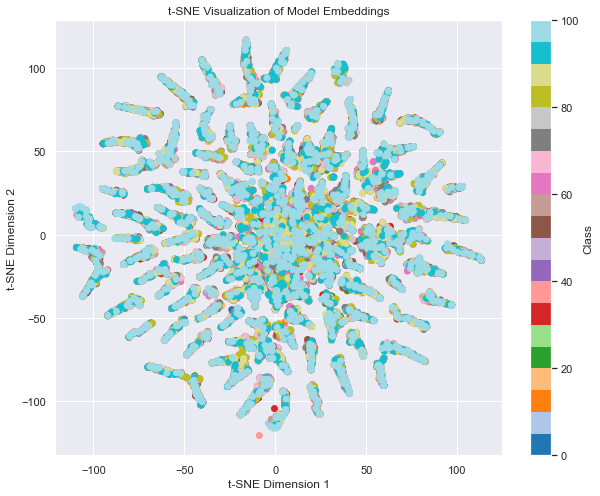

In [19]:
# Extract embeddings for the test dataset
test_embeddings = mobile_net.predict(test_generator)

# Apply t-SNE to reduce dimensions to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
test_embeddings_tsne = tsne.fit_transform(test_embeddings)

# Use label_encoder to transform the test set categories
test_labels = label_encoder.transform(test_data['category'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(test_embeddings_tsne[:, 0], test_embeddings_tsne[:, 1], c=test_labels, cmap='tab20')
plt.title('t-SNE Visualization of Model Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Class')
plt.show()

--> Ploting of the t-SNE visualization to reveal patterns and separability of different classes adn understand how well the model has learned to distinguish between different classes. Unfortunately, it hard to tell with too many classes.